In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os
import sys
import pandas as pd
import numpy as np
import torch
import pickle
import matplotlib.pyplot as plt
from collections import defaultdict

In [ ]:
from mixture_model_base import MixtureModelBase
from mixture_model import MixtureModel
from mixture_model_1S import MixtureModel1S
from order_stat_mixture_model import OrderStatMixtureModel
from order_stat_mixture_model_v2 import OrderStatMixtureModelV2
from xlms import XLMS_Dataset
from myutils import *


In [ ]:
def collect_models_for_initskew(initskew_dir):
    p = f'{initskew_dir}/models.pickle'
    if not os.path.exists(p):
        return
    models = pickle.load(open(p, 'rb'))
    # models = pd.DataFrame(models)
    # models = NamedTensor(models.values, names=['randi', 'attr'])
    # print(models.shape)
    # print(
    return models

In [ ]:
def collect_models_for_dataset(dataset_dir):
    models = []
    for initskew in os.listdir(dataset_dir):
        d = f'{dataset_dir}/{initskew}'
        if not os.path.isdir(d):
            continue
        x = collect_models_for_initskew(d)
        if x is None:
            continue
        models.append(x)
    return np.array(models)

In [ ]:
def collect_models_for_strategy(config, strategy, nsamples=2):
    d = f'../figures_python_diffsign_{nsamples}S2_{config}_{strategy}_initskew_1_2_5/'
    models = []
    for dataset in sorted(os.listdir(d)):
        # if dataset == 'D1810':
        #     continue
        ds_d = d + dataset
        if not os.path.isdir(ds_d):
            continue
        print(dataset)
        x = collect_models_for_dataset(ds_d)
        if x is None:
            return
        models.append(x)
    return np.array(models)

In [ ]:
config = 'unweighted_pdf_mode'

In [ ]:
models_1s = (collect_models_for_strategy(config, 'gaussian', nsamples=1))
models_1s = np.array(models_1s)

In [ ]:
models_2s = (collect_models_for_strategy(config, 'gaussian'))
models_2s = np.array(models_2s)

In [ ]:
models_2s_nc = (collect_models_for_strategy('no_constraint', 'gaussian'))
models_2s_nc = np.array(models_2s_nc)

In [11]:
# use 2s as 1s res for now
# models_1s = models_2s[:]

In [11]:
datasets = [
    'ALott',
    'Alinden',
    'CPSF',
    'D1810',
    'MS2000225',
    'QE',
    'RPA',
    'alban',
    'ecoli_xl',
    'peplib',
]

In [27]:
plot_datasets = datasets

In [14]:
plot_datasets = [
    'Alinden',
    'CPSF',
    'D1810',
    'MS2000225',
    'QE',
    'RPA',
    'ALott',
    'alban',
    'ecoli_xl',
    'peplib',
]

In [14]:
plot_datasets = ['ALott', 'Alinden', 'alban', 'ecoli_xl',]

In [12]:
dataset_ind = {d: i for i, d in enumerate(datasets)}

In [15]:
N = len(plot_datasets)

In [16]:
models_1s.shape

(10, 6, 40)

In [17]:
def load_dataset(dataset_name):
    tda_info = json.load(open(f'../results/info/{dataset_name}.json'))
    dataset = XLMS_Dataset(dataset_name, nodup=True)
    # dataset.mat = dataset.mat[:, dataset.mat[1, :] != 0]
    return dataset, tda_info

In [18]:
def plot_model(model, dataset_name, figfile):
    basedir = os.path.dirname(figfile)
    if not os.path.exists(basedir):
        os.makedirs(basedir)
    tda_info = json.load(open(f'../results/info/{dataset_name}.json'))
    dataset = XLMS_Dataset(dataset_name, nodup=True)
    # dataset.mat = dataset.mat[:, dataset.mat[1, :] != 0]

    best = model
    if 'slls' not in best:
        best['slls'] = best['model'].sep_log_likelihood(dataset.mat.T)
    if best['ll'] == -np.inf:
        print('no solution for', dataset_name)
        return
    tda_fdr1 = tda_info['fdr_thres']
    # best['model'].plot(dataset.mat.T, best['lls'], best['model'].sep_log_likelihood(dataset.mat.T))
    fig = plt.figure(figsize=(16, 9))
    MixtureModelBase._plot(dataset.mat.T, best['lls'], best['slls'], best['model'], fig)
    # plt.subplot(3, 1, 1)
    ax = fig.axes[0]
    # plt.axes(ax)
    ax.axvline(tda_fdr1, linestyle='--')
    ax.text(tda_fdr1, 0.003, '$\leftarrow$ TDA 1% FDR threshold')
    if 'cons_sat' in best:
        ax.set_title(
            f"{dataset_name} {best['sls']} ll={best['ll']:.05f}"
            f" constraints={get_cons_str(settings[config]['constraints'])}"
            f" {'Y' if best['cons_sat'] else 'N'}")
    else:
        ax.set_title(
            f"{dataset_name} {best['sls']} ll={best['ll']:.05f}"
            f" constraints={get_cons_str(settings[config]['constraints'])}")
    fig.savefig(figfile)


In [19]:
BIN_WIDTH = 5

In [20]:
def calc_fdr_curve(frozen_model):
    x = frozen_model.plotting_xrange
    tp = frozen_model.weights[0]['C'] * (1 - frozen_model.all_comps['C'].cdf(x))
    fpic = frozen_model.weights[0]['IC'] * (1 - frozen_model.all_comps['IC'].cdf(x))
    fpi1 = frozen_model.weights[0]['I1'] * (1 - frozen_model.all_comps['I1'].cdf(x))
    fp = fpic + fpi1
    fdr = fp / (tp + fp)
    return fdr


In [21]:
idmap = defaultdict(lambda: len(idmap))

In [22]:
hist_settings = {
    'facecolor': (76/255, 189/255, 237/255, 0.1),
    'ec': (76/255, 189/255, 237/255, 0.3),
    'lw': 1,
}

In [23]:
hist2_settings = {
    'facecolor': (0.4660, 0.6740, 0.1880, 0.1),
    'ec': (0.4660, 0.6740, 0.1880, 0.3),
    'lw': 1,
}

In [139]:
hist_settings = {
    'facecolor': (237/255, 248/255, 253/255),
    'ec': (201/255, 235/255, 250/255),
    'lw': 1,
}

In [140]:
hist2_settings = {
    'facecolor': (241/255, 247/255, 234/255),
    'ec': (214/255, 230/255, 193/255),
    'lw': 1,
}

In [34]:
def plot_model_s1(model, dataset, tda_info, ax, show_legend=False, show_ylabel=False, show_yylabel=False, show_scores=False):
    global idmap
    
    X = dataset.mat.T

    # print(model.keys())
    frozen_model = model['model']

    if 'slls' not in model:
        model['slls'] = model['model'].sep_log_likelihood(dataset.mat.T)
    slls = model['slls']
    if model['ll'] == -np.inf:
        print('no solution for', dataset_name)
        return
    tda_fdr1 = tda_info['fdr_thres']

    
    xmax = np.max(X)
    xmin = -50
    x = frozen_model.plotting_xrange
    bins = np.arange(xmin, xmax + BIN_WIDTH, BIN_WIDTH)
    
    i = 0
    yi = np.zeros_like(x, dtype=float)
    legends = []
    for j, (cname, cdist) in enumerate(frozen_model.comps[i].items()):
        yj = frozen_model.weights[i][cname] * cdist.pdf(x)
        yi += yj
        ax.plot(x, yj, c='C%d' % idmap[cname])
        legends.append(cname)
    ymax = yi.max()
    for j, (cname, cdist) in enumerate(frozen_model.comps[i].items()):
        scdist = frozen_model.starting_pos.comps[i][cname]
        # print(f'plotting component {cname}')
        str_params = f'{frozen_model.weights[i][cname]:.2f}' \
                     f' {cname}: m={cdist.mu:.2f}({scdist.mu:.2f}),' \
                     f' s={cdist.sigma:.2f}({scdist.sigma:.2f}),' \
                     f' a={cdist.alpha:.2f}({scdist.alpha:.2f})'
        # ax.text(xmin, ymax * (1 - 0.1 * (j + 1)), str_params)
    # print('draw mixture')
    ax.plot(x, yi, c='C%d' % idmap['mixture'])
    legends.append(f'mixture{i + 1}')
    # print('draw hist')
    ax.hist(X[:, i], bins=bins, density=True, **hist_settings)
    ax.text(0.68, 0.9, f'll = {slls[i]:.3f}', transform=ax.transAxes)
    # print('draw legends')

    if show_legend:
        ax.legend(legends, loc=2)

    if show_ylabel:
        ax.set_ylabel('S1')

    fdr1 = frozen_model.fdr_thres
    ax.axvline(fdr1)
    # ax.text(fdr1, 0.005, '$\leftarrow$ 1% FDR threshold')
    print(f'1% FDR thres={fdr1}')
    
    ax.axvline(tda_fdr1, linestyle='--')
    # plt.text(tda_fdr1, 0.003, '$\leftarrow$ TDA 1% FDR threshold')

    
    ax2 = ax.twinx()
    # ax2.cla()
    ax2.set_ylim(0, 1)
    try:
        fdr_curve = frozen_model.fdr_curve
    except:
        fdr_curve = calc_fdr_curve(frozen_model)
    ax2.plot(x, fdr_curve)

    if show_yylabel:
        ax2.set_ylabel('FDR', rotation=-90, position=(0,0.2))
    else:
        ax.tick_params(which='both', labelright=False)
        ax2.tick_params(which='both', labelright=False)

    # ax.set_title(dataset)
    ax.tick_params(which='both', labelleft=False)
    ax2.tick_params(which='both', labelleft=False)
    if not show_scores:
        ax.tick_params(which='both', labelbottom=False)
        ax2.tick_params(which='both', labelbottom=False)
        
    

In [35]:
def plot_model_s2(model, dataset, tda_info, ax, show_legend=False, show_ylabel=False, show_scores=False):
    global idmap
    
    X = dataset.mat.T

    # print(model.keys())
    frozen_model = model['model']

    if 'slls' not in model:
        model['slls'] = model['model'].sep_log_likelihood(dataset.mat.T)
    slls = model['slls']
    if model['ll'] == -np.inf:
        print('no solution for', dataset_name)
        return
    tda_fdr1 = tda_info['fdr_thres']

    
    xmax = np.max(X)
    xmin = -50
    x = frozen_model.plotting_xrange
    bins = np.arange(xmin, xmax + BIN_WIDTH, BIN_WIDTH)
    # idmap = defaultdict(lambda: len(idmap))
    
    i = 1

    reweight_scale = 1 / (1 - frozen_model.weights[i]['NA'].get())
    
    yi = np.zeros_like(x, dtype=float)
    legends = []
    for j, (cname, cdist) in enumerate(frozen_model.comps[i].items()):
        if cname == 'NA':
            continue
        yj = frozen_model.weights[i][cname] * reweight_scale * cdist.pdf(x)
        yi += yj
        ax.plot(x, yj, c='C%d' % idmap[cname])
        legends.append(cname)
    ymax = yi.max()
    for j, (cname, cdist) in enumerate(frozen_model.comps[i].items()):
        if cname == 'NA':
            continue
        scdist = frozen_model.starting_pos.comps[i][cname]
        # print(f'plotting component {cname}')
        str_params = f'{frozen_model.weights[i][cname]:.2f}' \
                     f' {cname}: m={cdist.mu:.2f}({scdist.mu:.2f}),' \
                     f' s={cdist.sigma:.2f}({scdist.sigma:.2f}),' \
                     f' a={cdist.alpha:.2f}({scdist.alpha:.2f})'
        # ax.text(xmin, ymax * (1 - 0.1 * (j + 1)), str_params)
    # print('draw mixture')
    ax.plot(x, yi, c='C%d' % idmap['mixture'])
    legends.append(f'mixture{i + 1}')
    # print('draw hist')
    # ax.hist(X[:, i], bins=bins, density=True, facecolor='w', ec='k', lw=1)
    nonzero = X[:, i]
    nonzero = nonzero[nonzero != 0]
    ax.hist(nonzero, bins=bins, density=True, **hist2_settings)

    ax.text(0.68, 0.9, f'll = {slls[i]:.3f}', transform=ax.transAxes)
    # print('draw legends')
    if show_legend:
        ax.legend(legends, loc=2)

    if show_ylabel:
        ax.set_ylabel('S2')

    if not show_scores:
        ax.tick_params(which='both', labelbottom=False)
    # ax.set_title(frozen_model.title)
    ax.tick_params(which='both', labelleft=False, labelright=False)
    

In [32]:
def gen_ufunc(nin, nout):
    return lambda f: np.frompyfunc(f, nin, nout)

def reduce(f, arr, dims):
    r = arr
    for dim in dims:
        r = f.reduce(r, dim, keepdims=True)
    return r.squeeze(dims)

@gen_ufunc(2, 1)
def max_ll(x, y):
    if x['ll'] > y['ll']:
        return x
    else:
        return y

@gen_ufunc(1, 1)
def take_model(x):
    return x['model']

@gen_ufunc(1, 1)
def take_fdr_thres(x):
    return x.fdr_thres

In [41]:
info = json.load(open('../results/info/ALott.json'))
info

{'ndecoy': 200567,
 'ndd': 51112,
 'ntarget': 123095,
 'fdr_thres': 236.4272836456812,
 'scores': [281.8080913668195,
  279.3371100759825,
  278.34232591759474,
  278.292648498222,
  273.4288206390849,
  273.3838243752864,
  271.552630458189,
  270.9497737299378,
  270.224880218433,
  269.7390280004931,
  269.3222948847309,
  269.274184371549,
  268.7151966591078,
  268.6031090916753,
  268.518269331744,
  267.1071388401633,
  266.7108301111698,
  266.69456549820507,
  266.3163567598695,
  266.0174170626429,
  265.5473386622373,
  265.25470072290807,
  265.0101619402152,
  264.854888746578,
  264.5117496818325,
  264.4989802726263,
  264.461668848282,
  264.2591921822391,
  264.0961882860732,
  263.8161565990038,
  263.6433057338889,
  263.5867018339797,
  263.0304317176917,
  262.9811876945265,
  262.9388647477752,
  262.8369235964757,
  262.6293199180803,
  262.3435808358027,
  262.2630654171735,
  262.2436707055797,
  262.2317280332583,
  262.0519550847495,
  261.59577317799926,
  2

In [27]:
def capitalize(s):
    return s[0].upper() + s[1:]

{'mat': array([[ 96.5485413 ,  92.97922496,  91.913342  , ..., 174.70944811,
        155.95243559,  41.12319712],
       [  0.        ,  86.91293446,  62.32423515, ..., 120.54421487,
        136.23064076,  36.44308847]])}
dict_keys(['ndecoy', 'ndd', 'ntarget', 'fdr_thres', 'scores', 'curve_fdr', 'curve_decoy', 'curve_dd', 'curve_matches'])
{'mat': array([[ 94.65938595, 115.29969757,  47.48114986, ..., 145.66883013,
        158.56712418, 126.57273559],
       [ 93.79731741,  99.92061167,  35.36135989, ..., 144.67486406,
        150.00842603, 124.38098113]])}
dict_keys(['ndecoy', 'ndd', 'ntarget', 'fdr_thres', 'scores', 'curve_fdr', 'curve_decoy', 'curve_dd', 'curve_matches'])
{'mat': array([[124.99339504, 117.30916394,  99.68714052, ..., 108.79144509,
         95.82212858,  88.75812833],
       [121.54304036, 108.21935916,  98.14698048, ..., 104.61096083,
         85.48101457,   0.        ]])}
dict_keys(['ndecoy', 'ndd', 'ntarget', 'fdr_thres', 'scores', 'curve_fdr', 'curve_decoy', 'cur

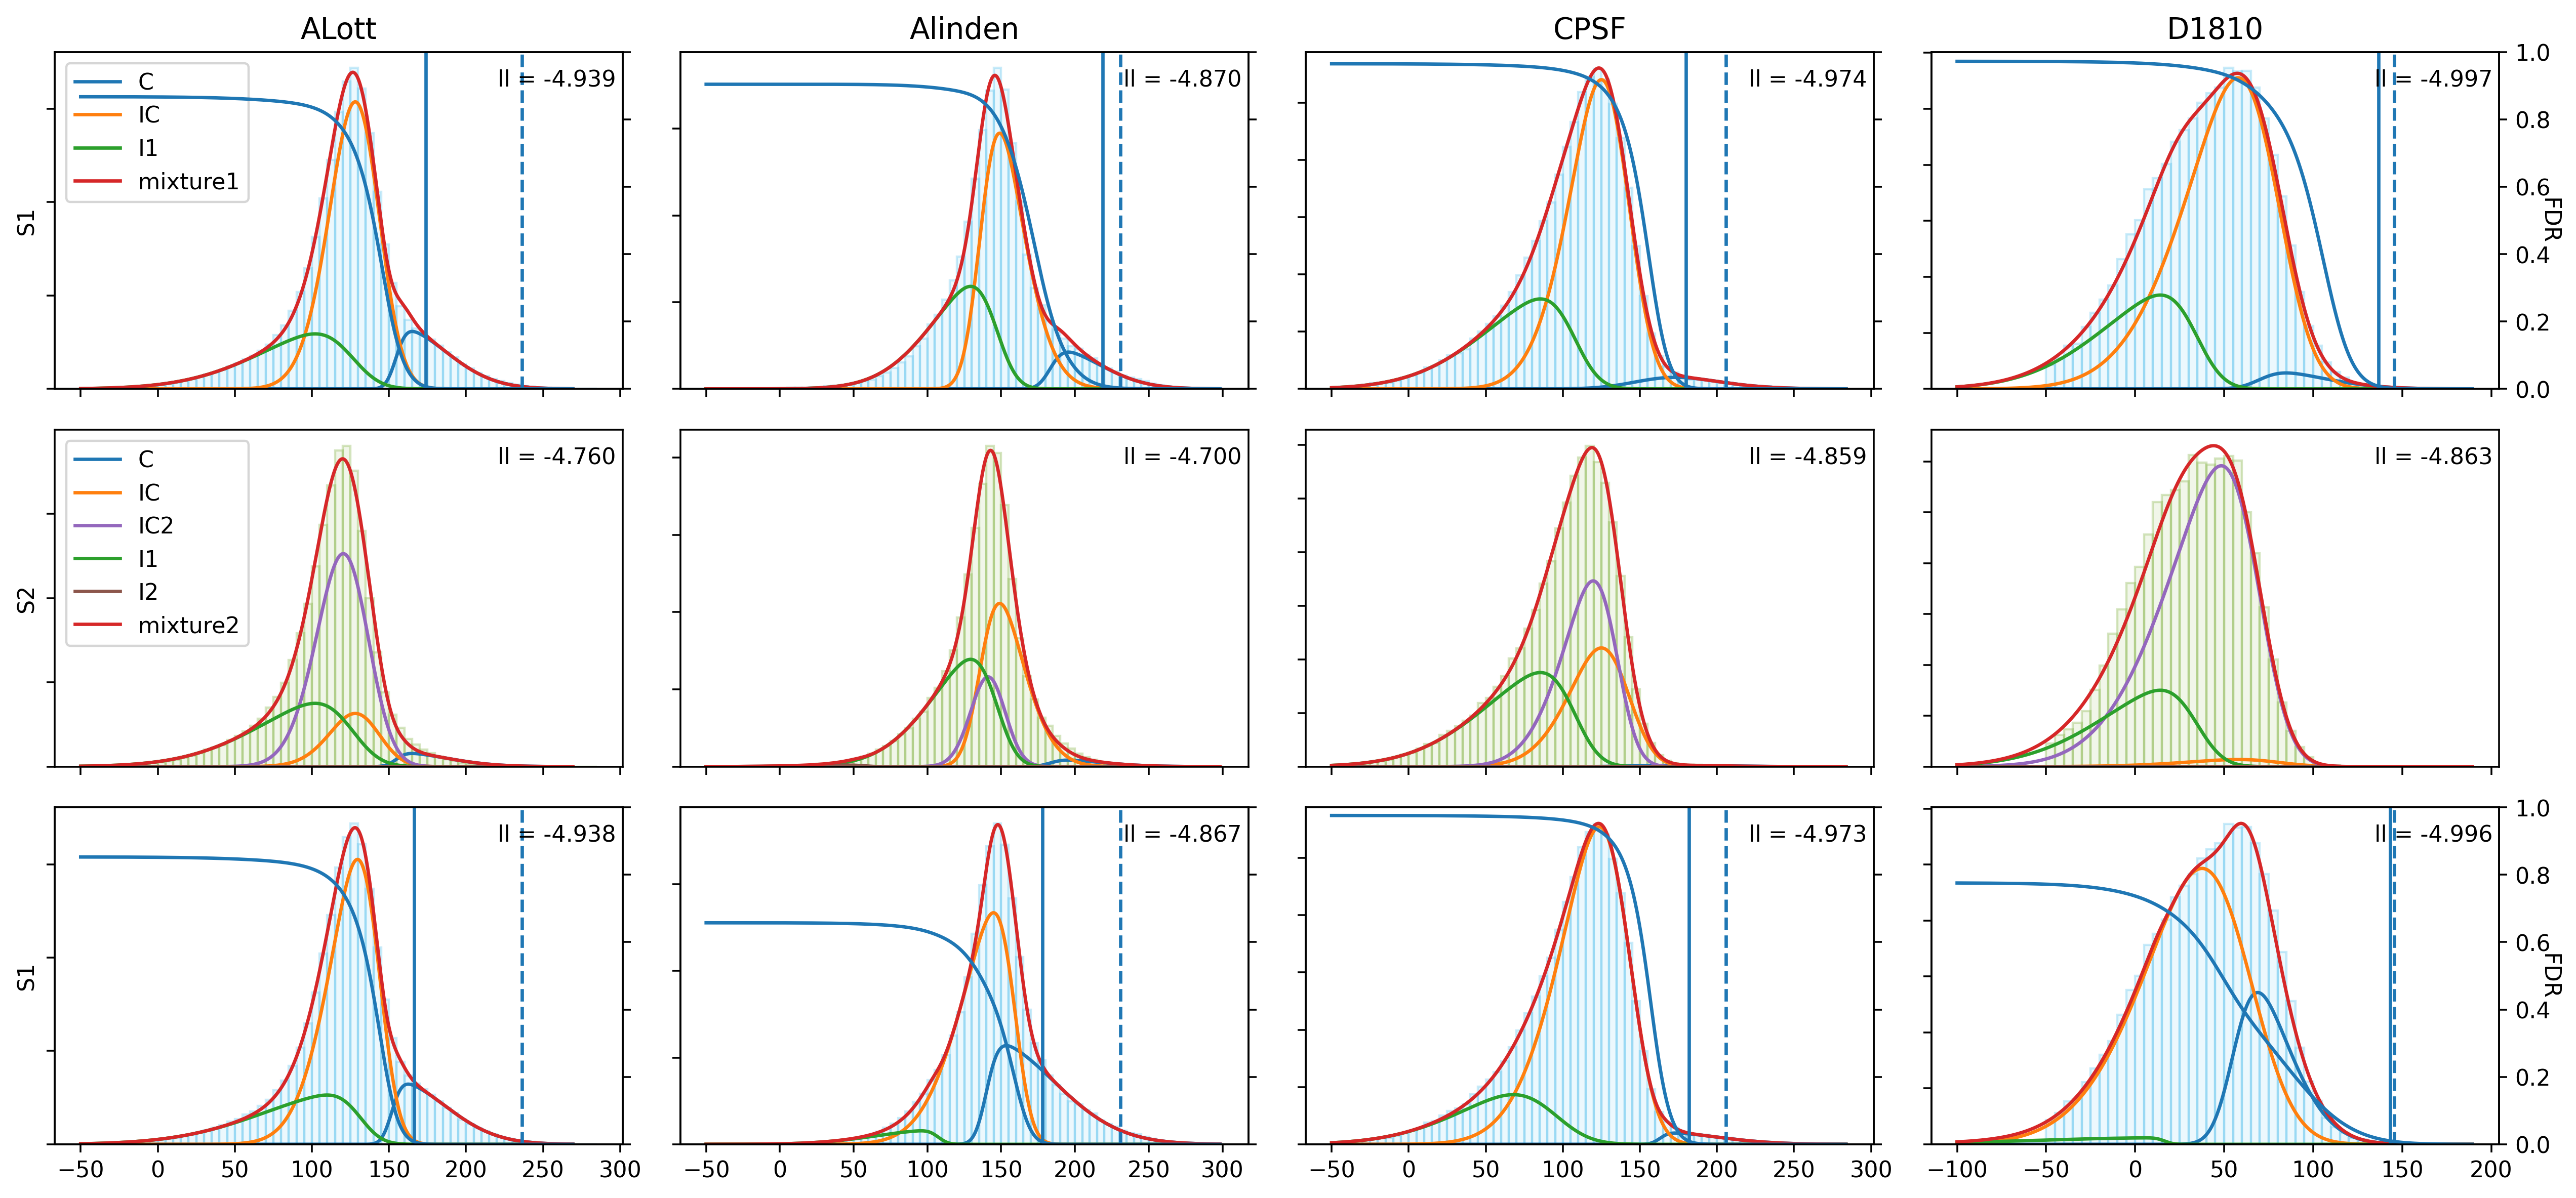

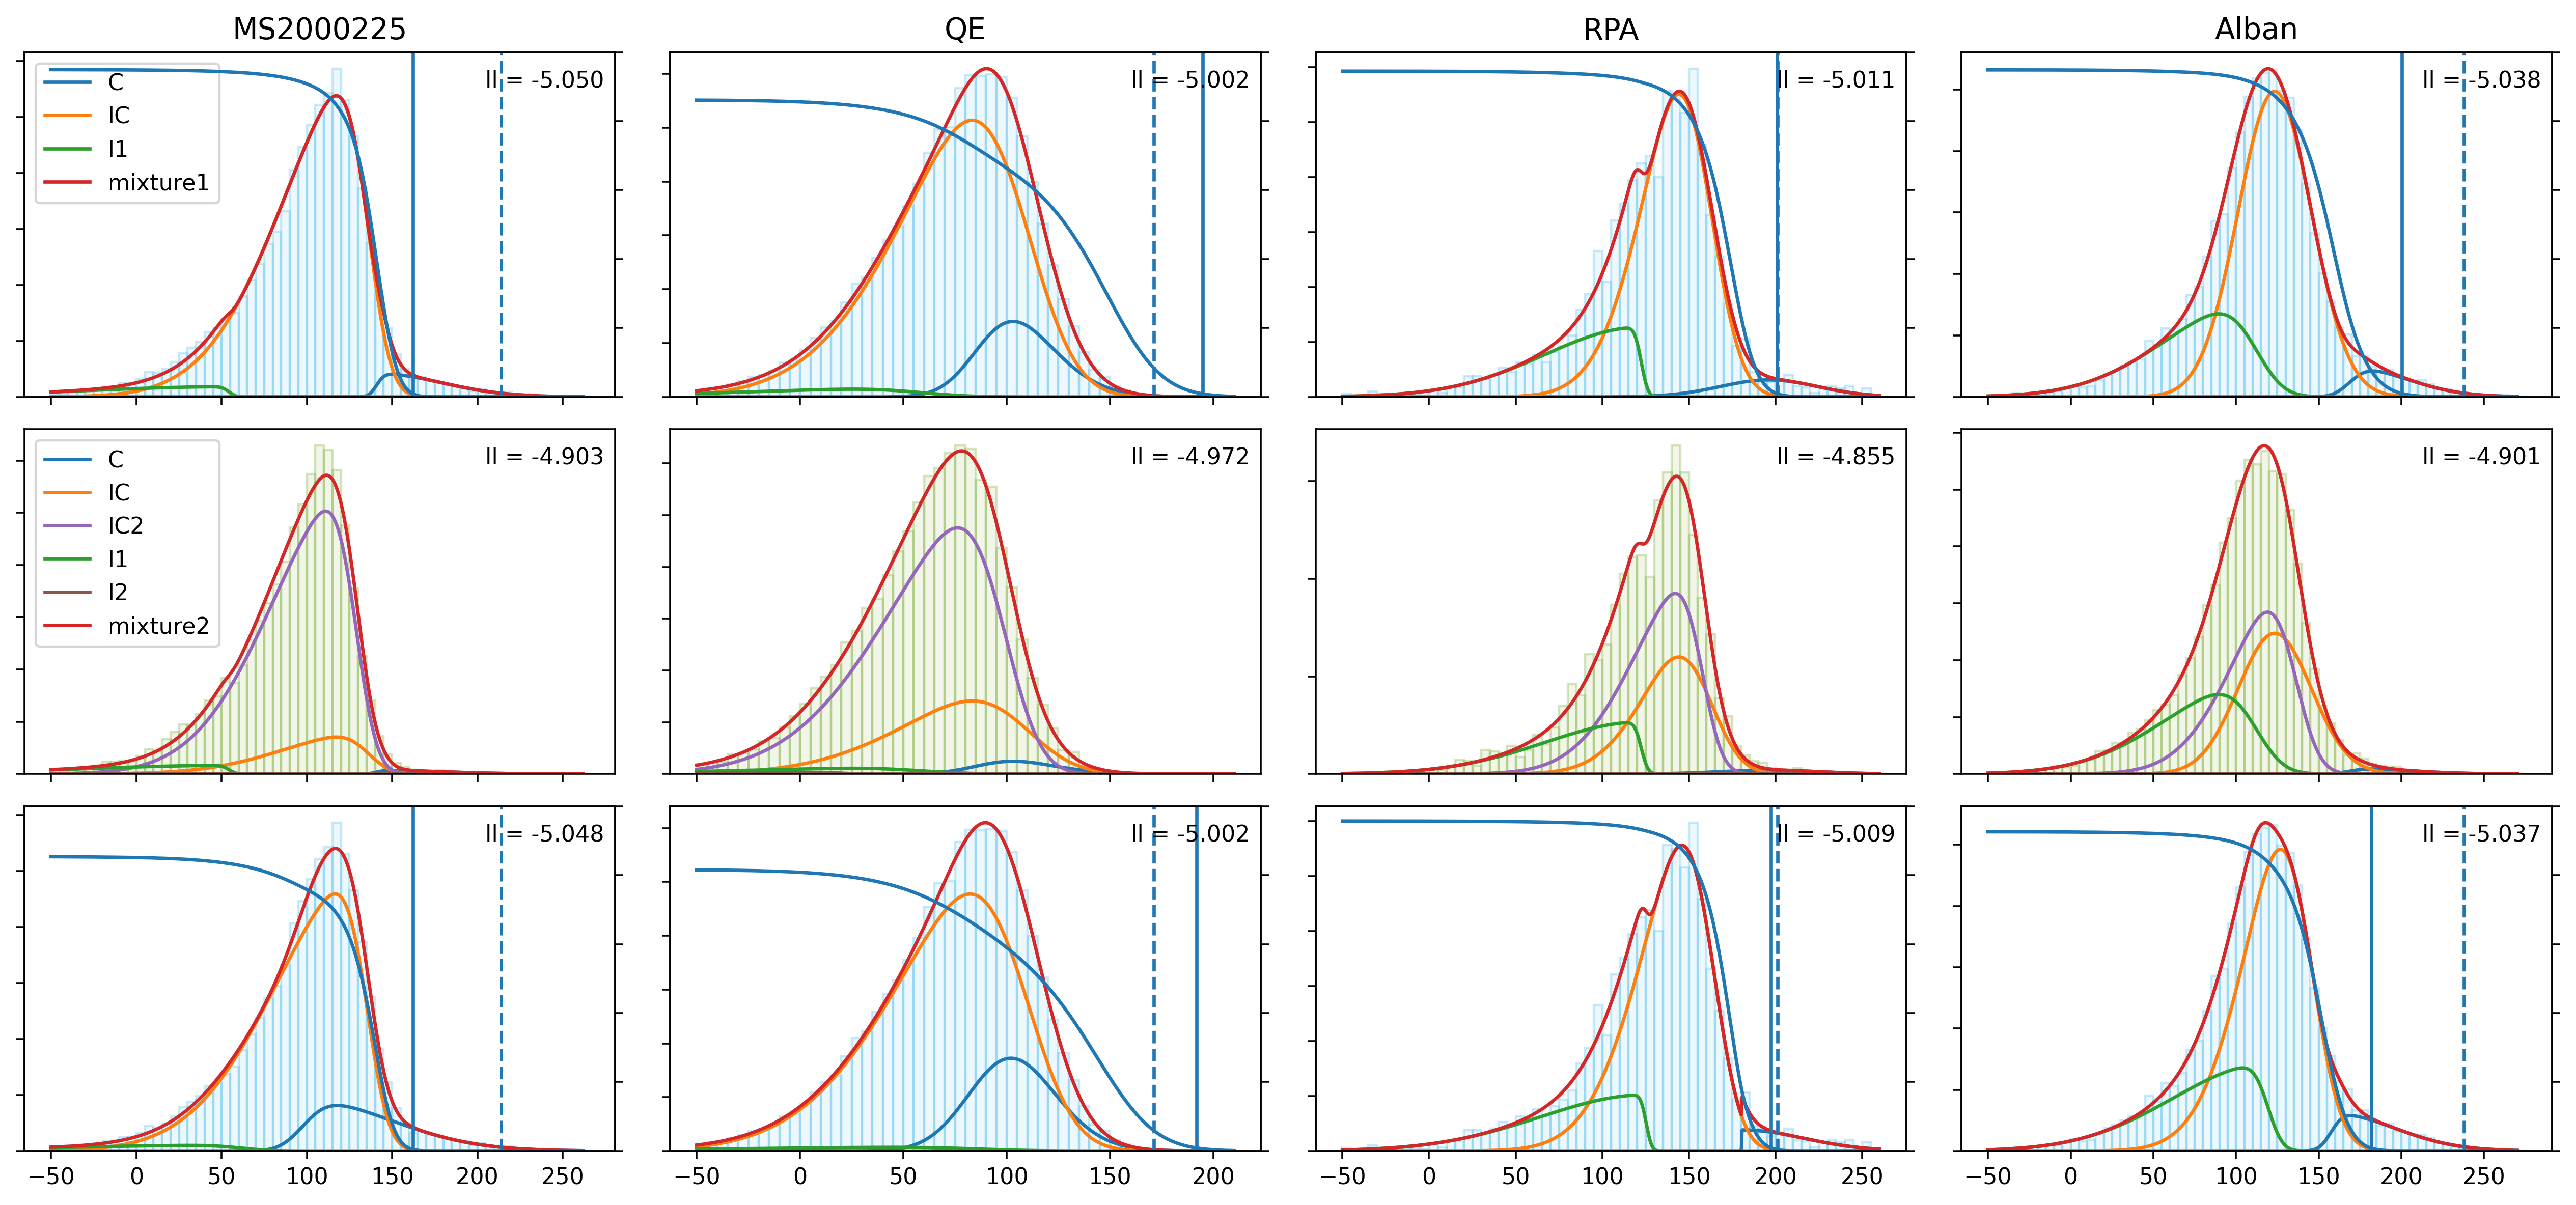

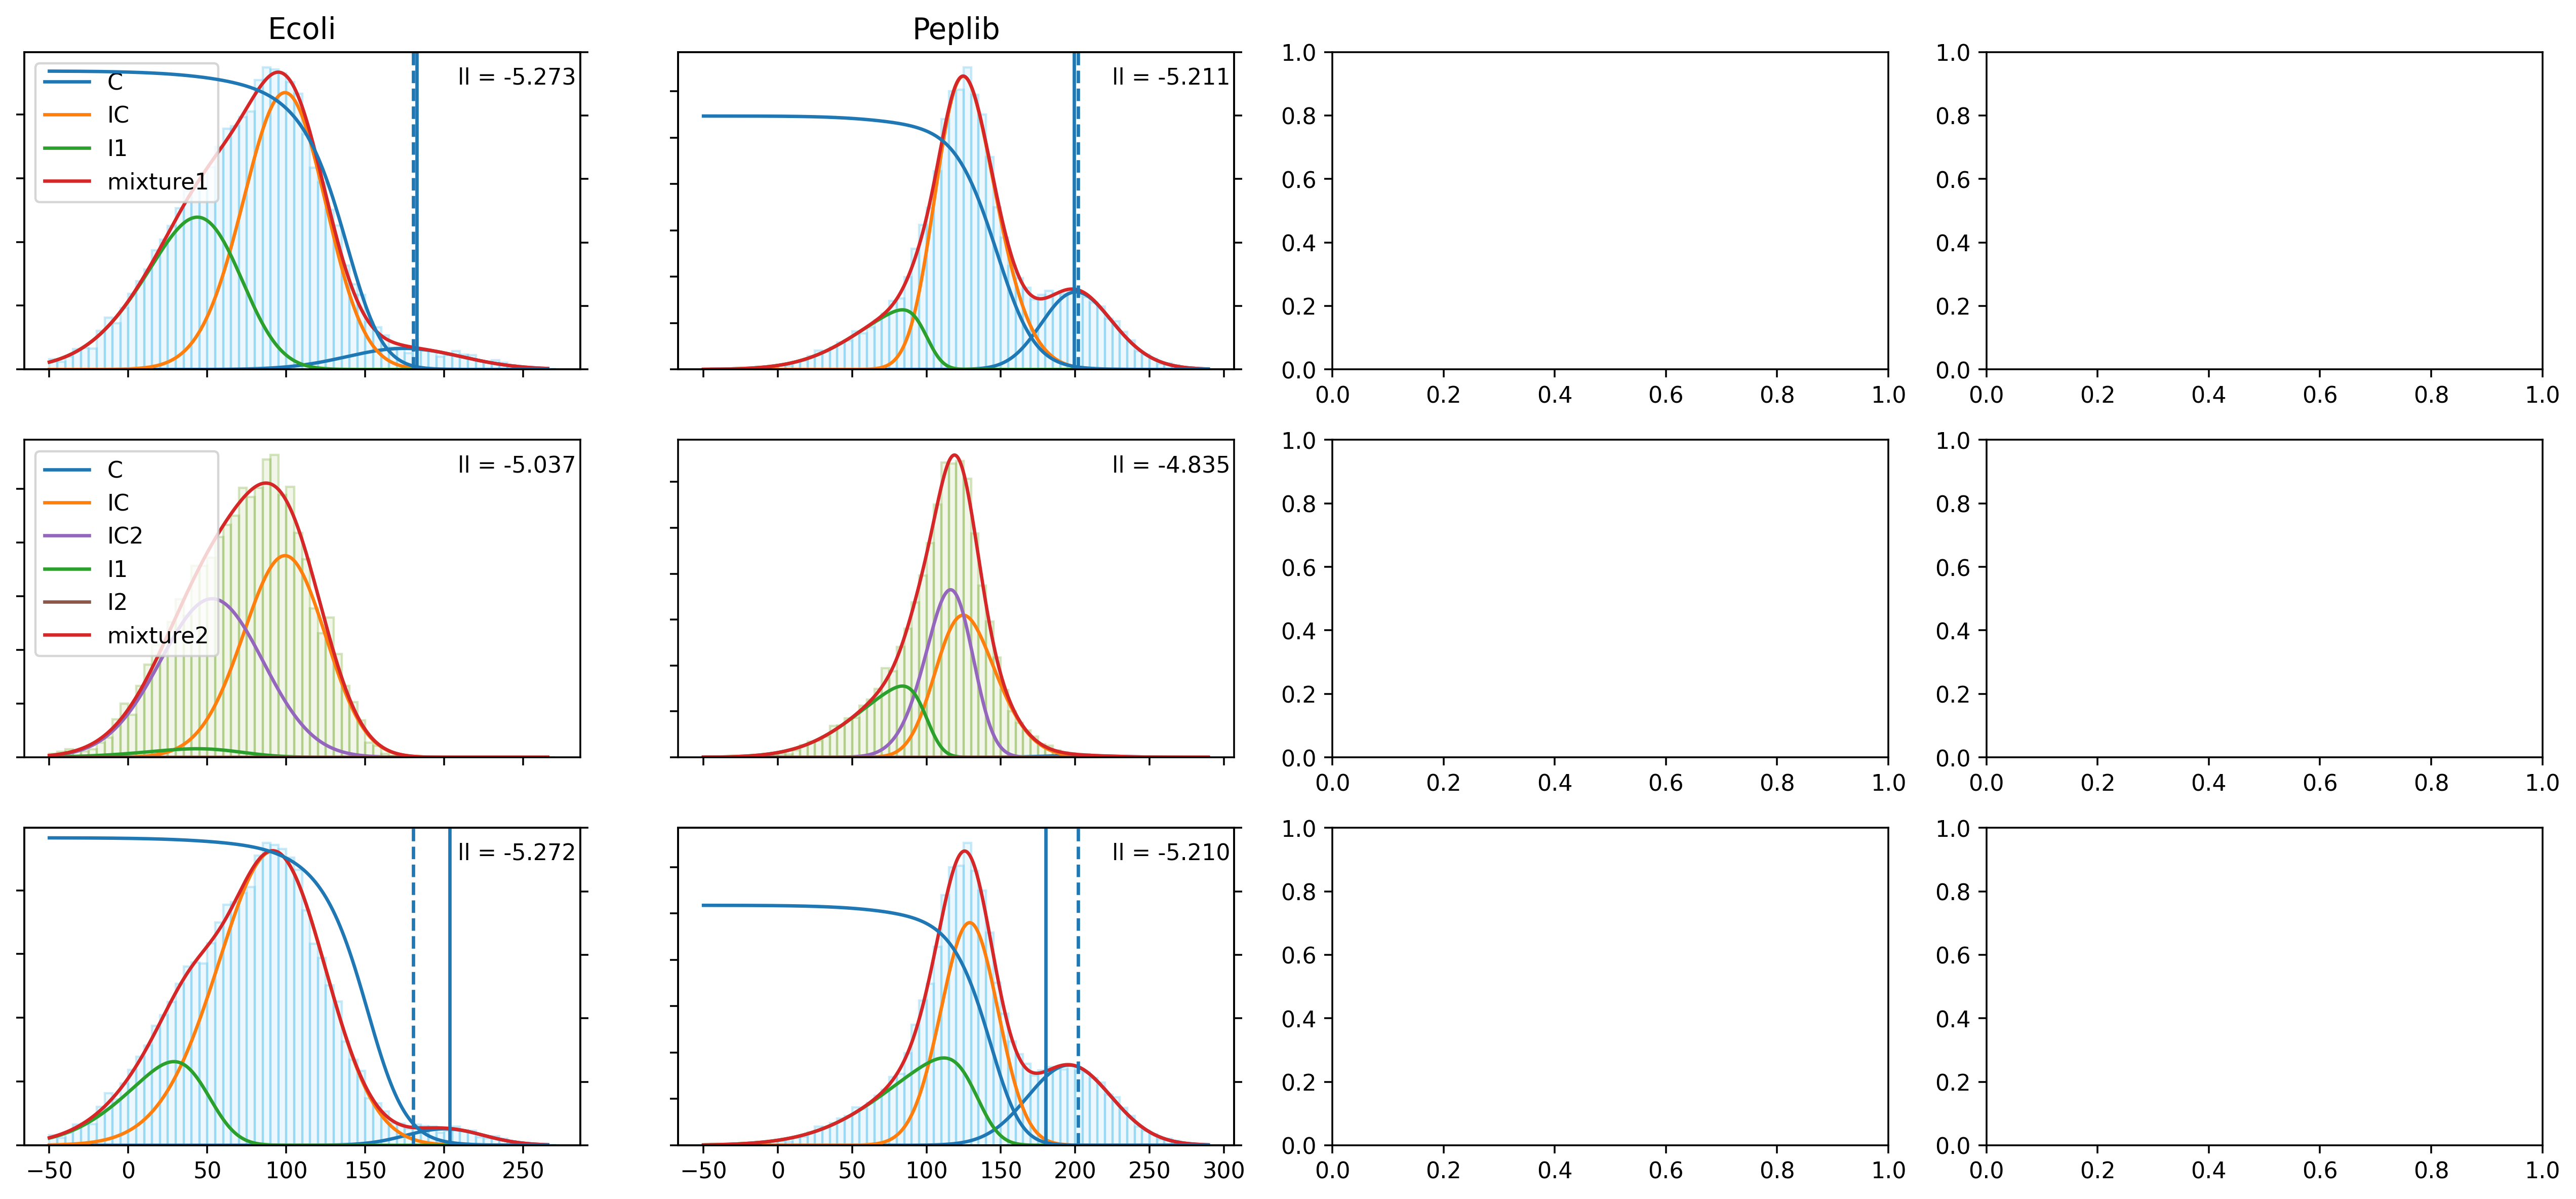

In [43]:
def plot_res(models_1s, models_2s):
    w = 16
    # fig = plt.figure(figsize=(w, w/6 * N), dpi=320)
    # fig.subplots(N, 3)
    fig = None
    ncol = 4
    nrow = 3
    for i, dataset_name in enumerate(plot_datasets):
        if i % ncol == 0:
            if fig:
                fig.tight_layout()
                # break
            fig = plt.figure(figsize=(w, 10 / ncol * nrow), dpi=320)
            fig.subplots(nrow, ncol)
            i_ax = 0
        ind = dataset_ind[dataset_name]

        dataset, tda_info = load_dataset(dataset_name)

        best_1s = reduce(max_ll, models_1s[ind], (0, 1))[()]
        best_2s = reduce(max_ll, models_2s[ind], (0, 1))[()]
        # print(best_1s.keys())
        if i % ncol == 0:
            show_legend = True
        else:
            show_legend = False
        plot_model_s1(best_2s, dataset, tda_info, fig.axes[i_ax], show_legend, show_ylabel=i==0, show_yylabel=i==ncol-1)
        plot_model_s2(best_2s, dataset, tda_info, fig.axes[i_ax+1*ncol], show_legend, show_ylabel=i==0)
        plot_model_s1(best_1s, dataset, tda_info, fig.axes[i_ax+2*ncol], show_ylabel=i==0, show_yylabel=i==ncol-1, show_scores=True)

        title = capitalize(dataset_name.replace('_xl', ''))
        fig.axes[i_ax].set_title(title, size=13)
        
        i_ax += 1
    
    fig.tight_layout()
    return fig
        
fig = plot_res(models_1s, models_2s)

In [28]:
plot_datasets = [
    'ecoli_xl',
    'peplib',
    'Alinden',
    'D1810',
    'ALott',
]

In [38]:
for dataset_name in plot_datasets:
    dataset, tda_info = load_dataset(dataset_name)
    print(dataset_name)
    print('TDA 1% FDR', tda_info['fdr_thres'])


{'mat': array([[ 4.22730708, 65.46571838,  2.48143805, ..., 89.83498406,
        75.89800946, 35.66559364],
       [ 0.        ,  0.        ,  0.        , ..., 47.82038944,
         0.        , 28.71999922]])}
dict_keys(['ndecoy', 'ndd', 'ntarget', 'fdr_thres', 'scores', 'curve_fdr', 'curve_decoy', 'curve_dd', 'curve_matches'])
ecoli_xl
TDA 1% FDR 180.2785621739637
{'mat': array([[139.71290565, 196.34045405, 121.74107556, ..., 135.69015612,
        111.7826202 , 112.76941546],
       [ 90.07695341, 186.13061128,  96.0243541 , ..., 124.56937649,
        110.212177  , 104.88785521]])}
dict_keys(['ndecoy', 'ndd', 'ntarget', 'fdr_thres', 'scores', 'curve_fdr', 'curve_decoy', 'curve_dd', 'curve_matches'])
peplib
TDA 1% FDR 202.11074546365919
{'mat': array([[ 94.65938595, 115.29969757,  47.48114986, ..., 145.66883013,
        158.56712418, 126.57273559],
       [ 93.79731741,  99.92061167,  35.36135989, ..., 144.67486406,
        150.00842603, 124.38098113]])}
dict_keys(['ndecoy', 'ndd', 'nt

ecoli_xl
{'mat': array([[ 4.22730708, 65.46571838,  2.48143805, ..., 89.83498406,
        75.89800946, 35.66559364],
       [ 0.        ,  0.        ,  0.        , ..., 47.82038944,
         0.        , 28.71999922]])}
dict_keys(['ndecoy', 'ndd', 'ntarget', 'fdr_thres', 'scores', 'curve_fdr', 'curve_decoy', 'curve_dd', 'curve_matches'])
1% FDR thres=182.73871351456722
1% FDR thres=224.1179930659839
peplib
{'mat': array([[139.71290565, 196.34045405, 121.74107556, ..., 135.69015612,
        111.7826202 , 112.76941546],
       [ 90.07695341, 186.13061128,  96.0243541 , ..., 124.56937649,
        110.212177  , 104.88785521]])}
dict_keys(['ndecoy', 'ndd', 'ntarget', 'fdr_thres', 'scores', 'curve_fdr', 'curve_decoy', 'curve_dd', 'curve_matches'])
1% FDR thres=199.43717131919956
1% FDR thres=180.29227453907967
Alinden
{'mat': array([[ 94.65938595, 115.29969757,  47.48114986, ..., 145.66883013,
        158.56712418, 126.57273559],
       [ 93.79731741,  99.92061167,  35.36135989, ..., 144.6748

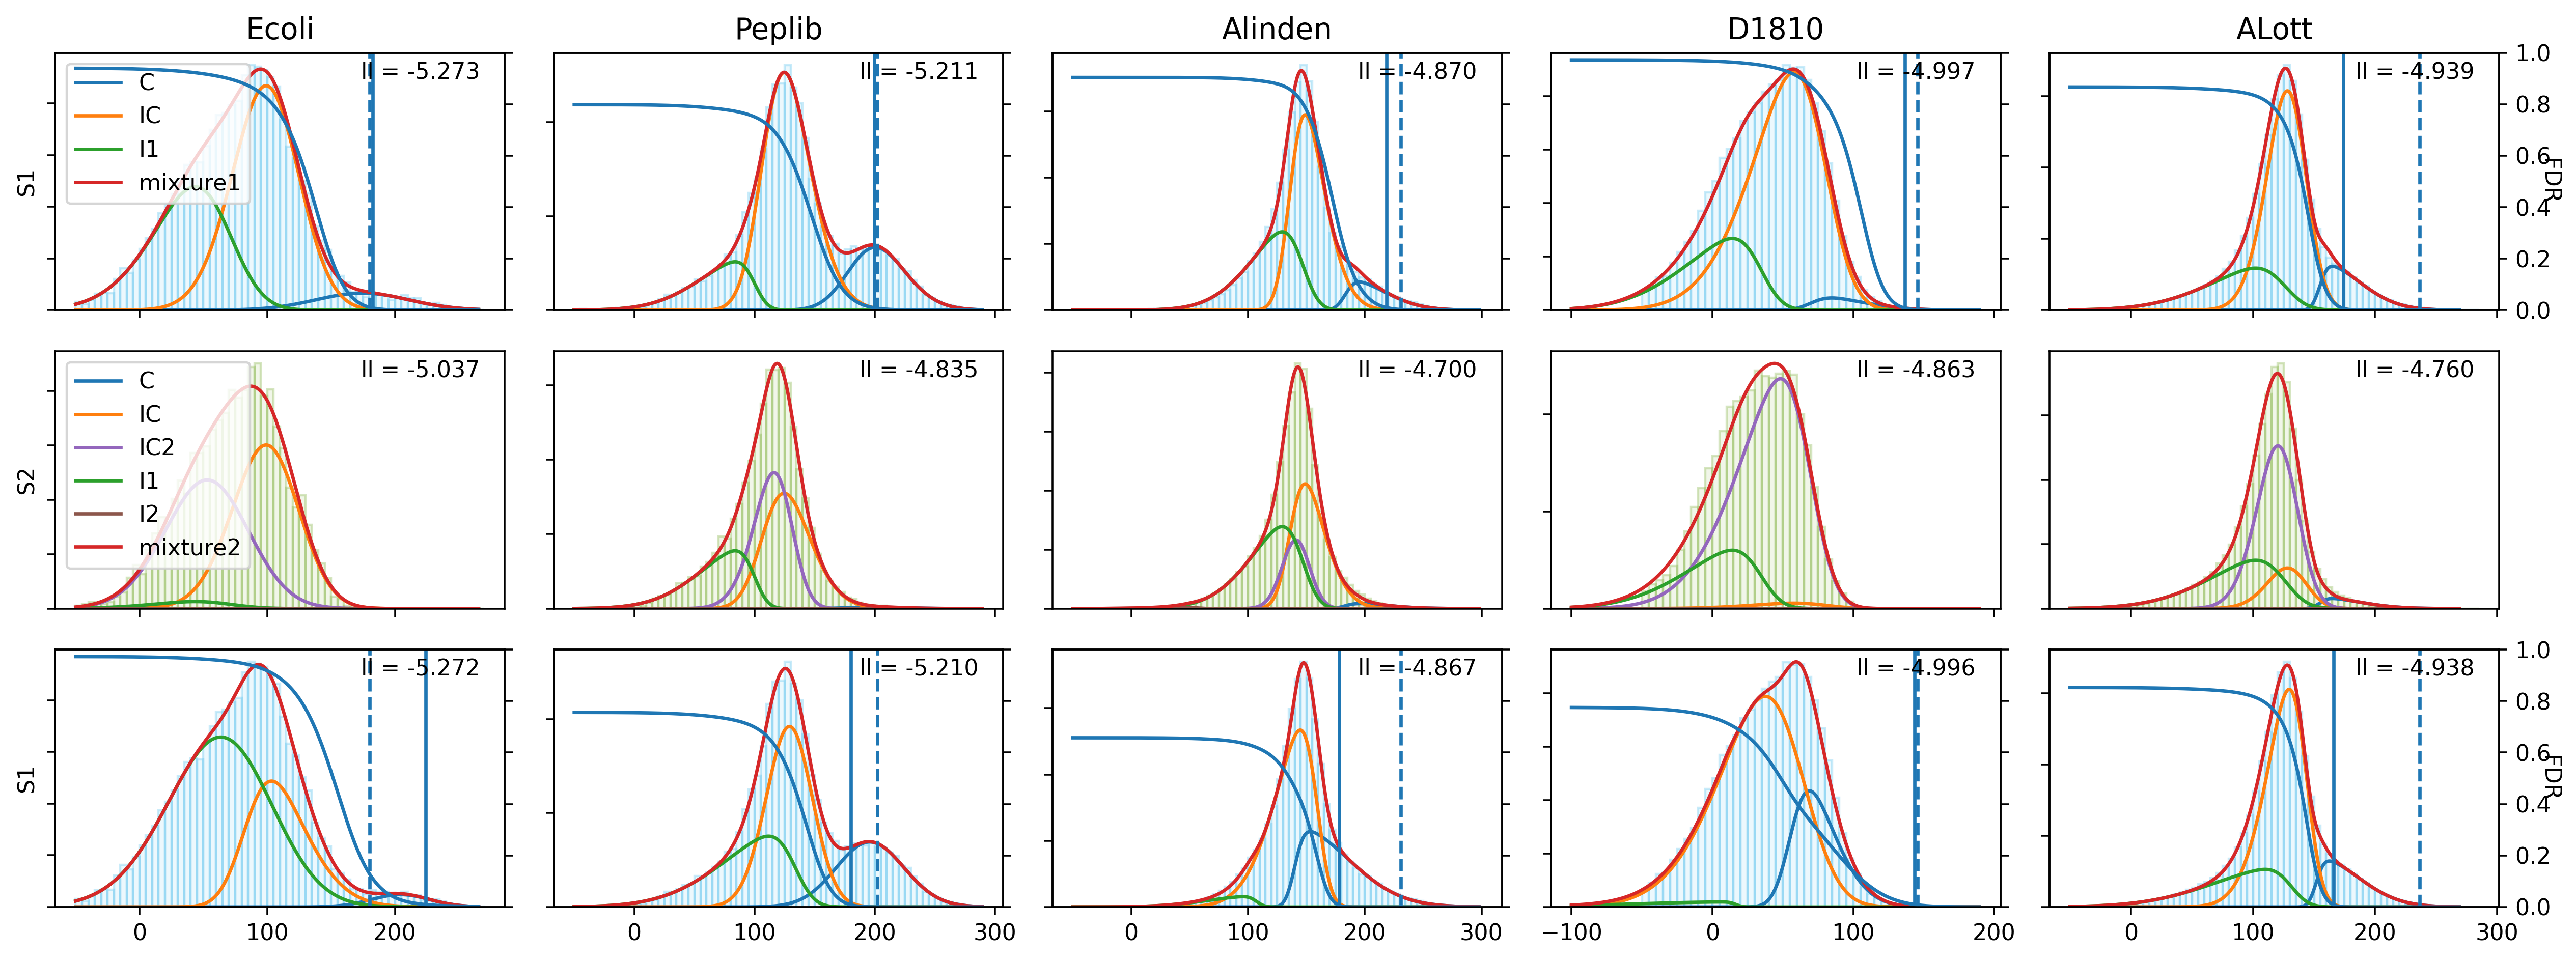

In [36]:
def plot_res(models_1s, models_2s):
    w = 16
    # fig = plt.figure(figsize=(w, w/6 * N), dpi=320)
    # fig.subplots(N, 3)
    fig = None
    ncol = 5
    nrow = 3
    for i, dataset_name in enumerate(plot_datasets):
    # for i, dataset_name in enumerate(datasets):
        print(dataset_name)
        if i % ncol == 0:
            if fig:
                fig.tight_layout()
                # break
            fig = plt.figure(figsize=(w, 10 / ncol * nrow), dpi=320)
            fig.subplots(nrow, ncol)
            i_ax = 0
        ind = dataset_ind[dataset_name]

        dataset, tda_info = load_dataset(dataset_name)

        best_1s = reduce(max_ll, models_1s[ind], (0, 1))[()]
        best_2s = reduce(max_ll, models_2s[ind], (0, 1))[()]
        # print(best_1s.keys())
        if i == 0:
            show_legend = True
        else:
            show_legend = False
        plot_model_s1(best_2s, dataset, tda_info, fig.axes[i_ax], show_legend, show_ylabel=i%ncol==0, show_yylabel=i%ncol==ncol-1)
        plot_model_s2(best_2s, dataset, tda_info, fig.axes[i_ax+1*ncol], show_legend, show_ylabel=i%ncol==0)
        plot_model_s1(best_1s, dataset, tda_info, fig.axes[i_ax+2*ncol], show_ylabel=i%ncol==0, show_yylabel=i%ncol==ncol-1, show_scores=True)

        title = capitalize(dataset_name.replace('_xl', ''))
        fig.axes[i_ax].set_title(title, size=13)
        
        i_ax += 1
    
    fig.tight_layout()
    return fig
    
fig = plot_res(models_1s, models_2s)

In [54]:
fig.savefig('../fitting_10.png')

{'mat': array([[ 96.5485413 ,  92.97922496,  91.913342  , ..., 174.70944811,
        155.95243559,  41.12319712],
       [  0.        ,  86.91293446,  62.32423515, ..., 120.54421487,
        136.23064076,  36.44308847]])}
dict_keys(['ndecoy', 'ndd', 'ntarget', 'fdr_thres', 'scores', 'curve_fdr', 'curve_decoy', 'curve_dd', 'curve_matches'])
{'mat': array([[ 94.65938595, 115.29969757,  47.48114986, ..., 145.66883013,
        158.56712418, 126.57273559],
       [ 93.79731741,  99.92061167,  35.36135989, ..., 144.67486406,
        150.00842603, 124.38098113]])}
dict_keys(['ndecoy', 'ndd', 'ntarget', 'fdr_thres', 'scores', 'curve_fdr', 'curve_decoy', 'curve_dd', 'curve_matches'])
{'mat': array([[124.99339504, 117.30916394,  99.68714052, ..., 108.79144509,
         95.82212858,  88.75812833],
       [121.54304036, 108.21935916,  98.14698048, ..., 104.61096083,
         85.48101457,   0.        ]])}
dict_keys(['ndecoy', 'ndd', 'ntarget', 'fdr_thres', 'scores', 'curve_fdr', 'curve_decoy', 'cur

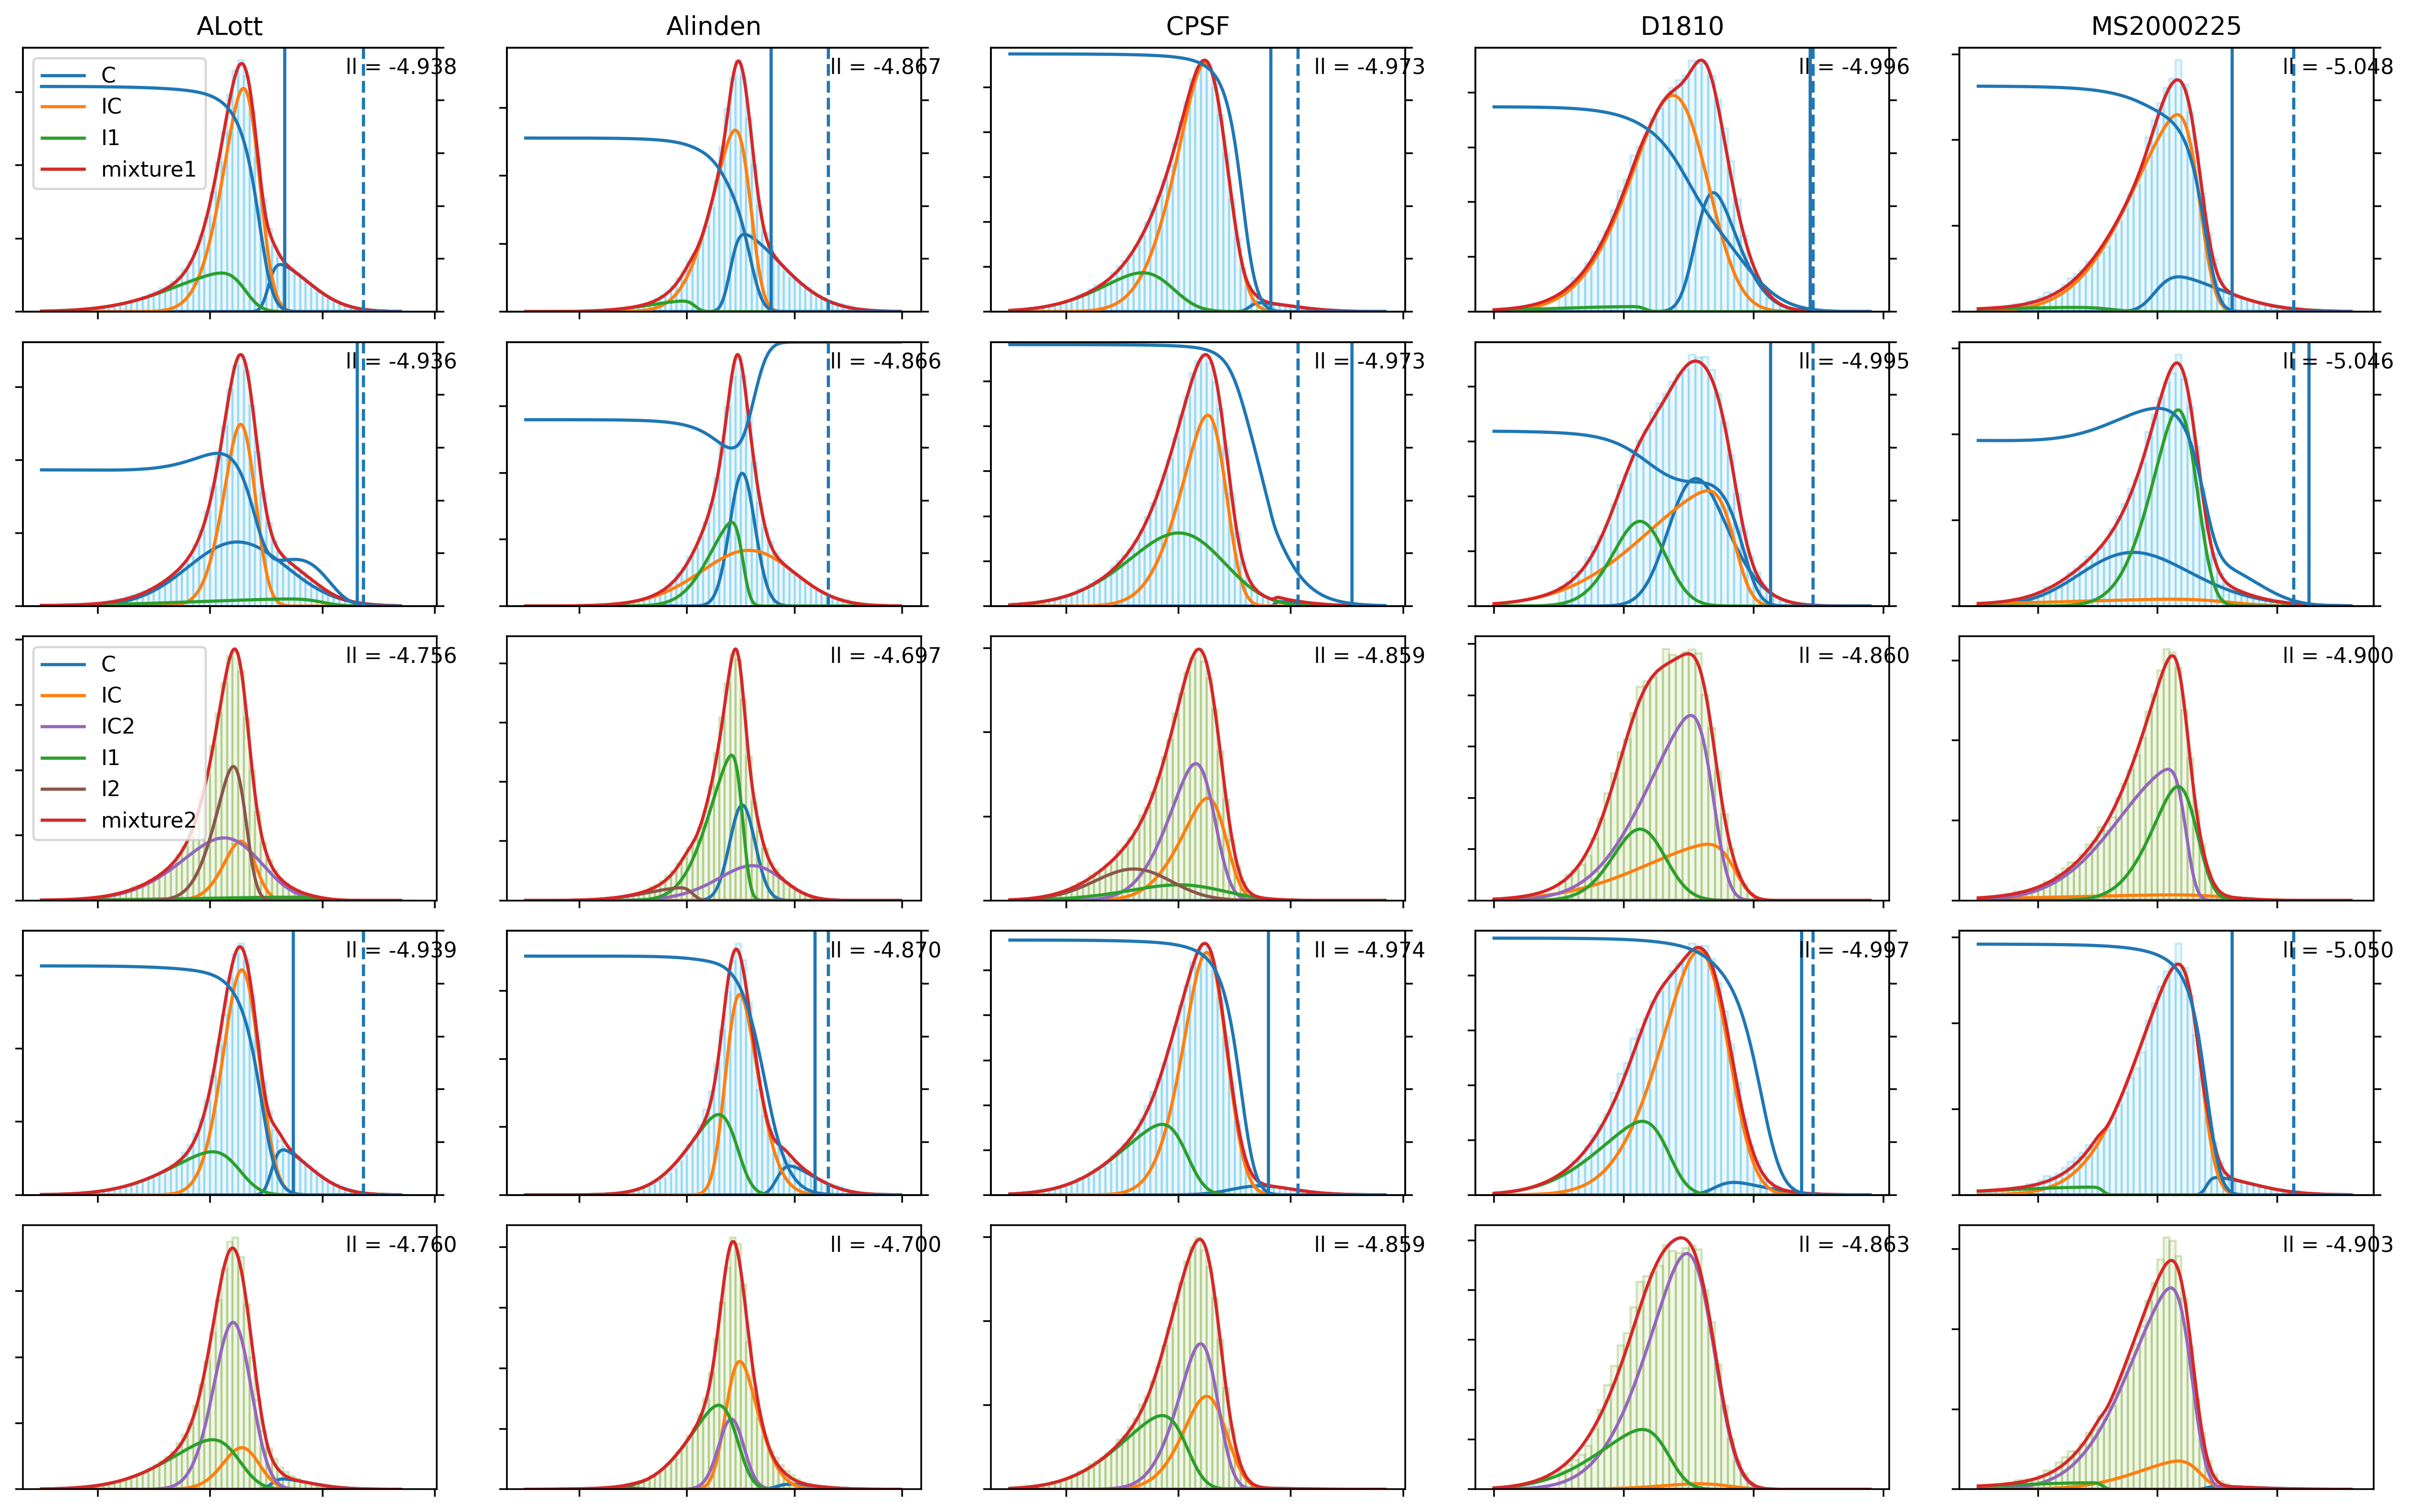

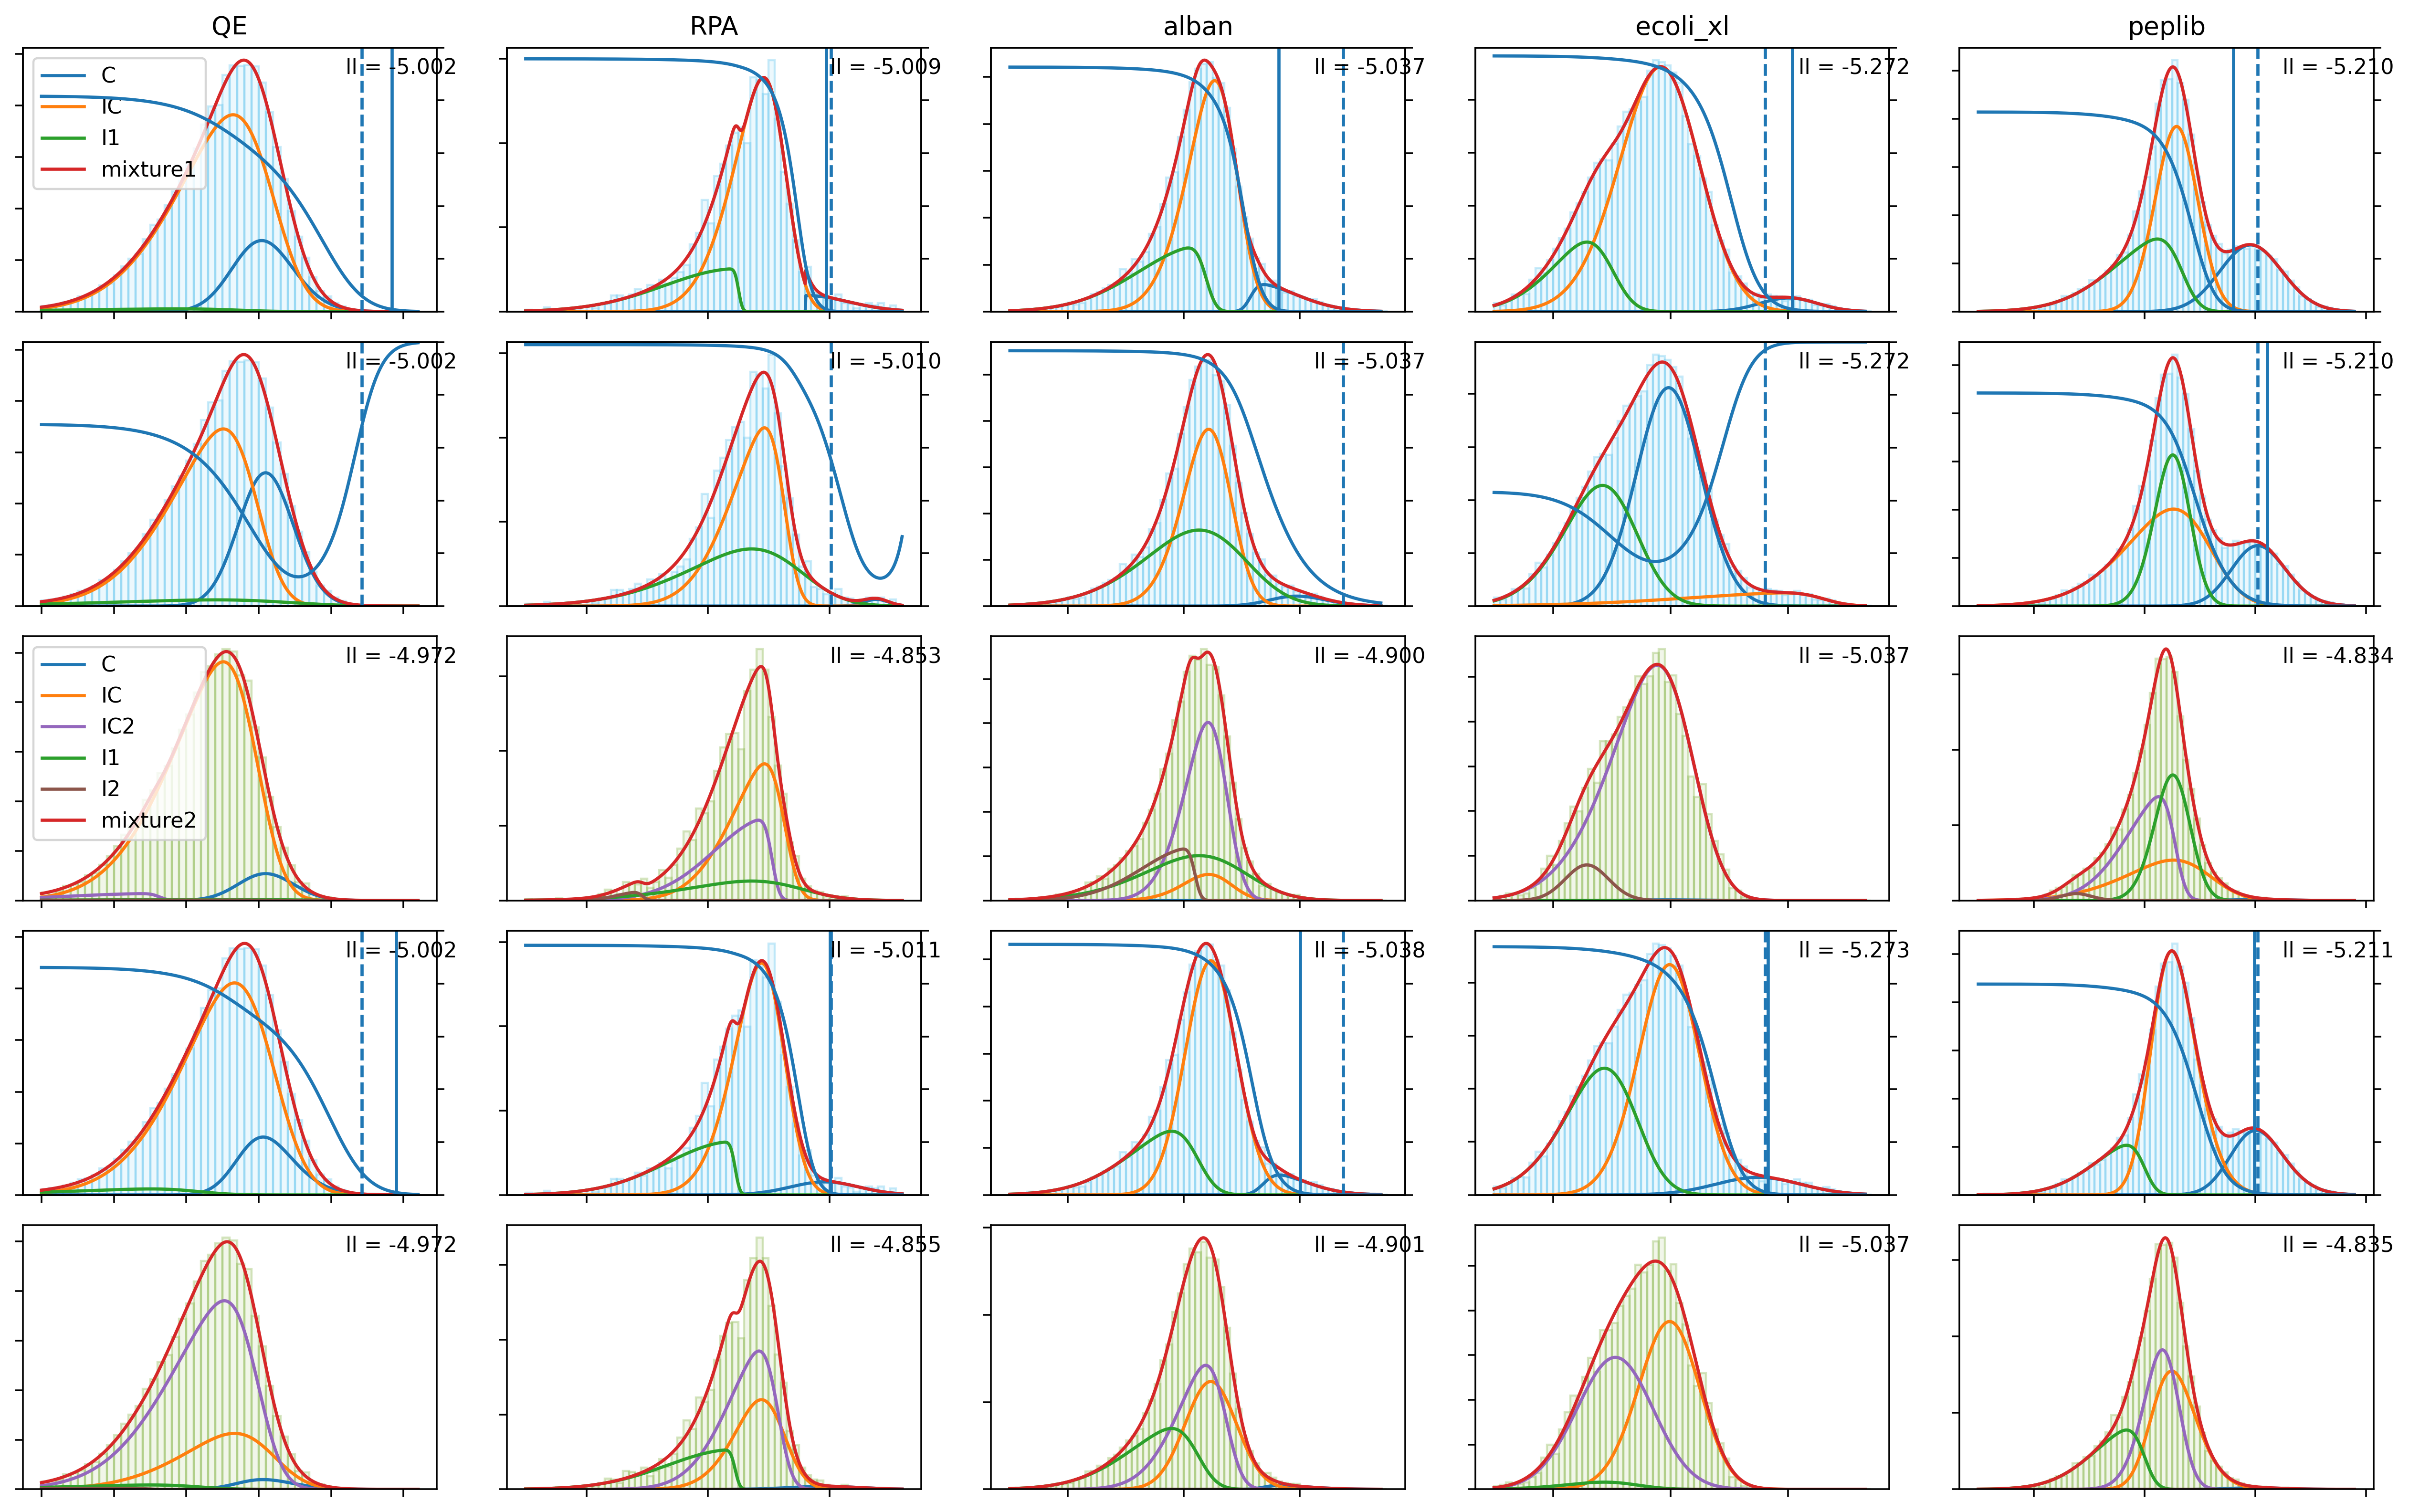

In [150]:
def plot_res2(models_1s, models_2s_nc, models_2s):
    w = 16
    # fig = plt.figure(figsize=(w, w/6 * N), dpi=320)
    # fig.subplots(N, 3)
    fig = None
    ncol = 5
    nrow = 5
    for i, dataset_name in enumerate(datasets):
        if i % ncol == 0:
            if fig:
                fig.tight_layout()
                # break
            fig = plt.figure(figsize=(w, 10 / ncol * nrow), dpi=320)
            fig.subplots(nrow, ncol)
            i_ax = 0
        ind = dataset_ind[dataset_name]

        dataset, tda_info = load_dataset(dataset_name)

        best_1s = reduce(max_ll, models_1s[ind], (0, 1))[()]
        best_2s_nc = reduce(max_ll, models_2s_nc[ind], (0, 1))[()]
        best_2s = reduce(max_ll, models_2s[ind], (0, 1))[()]
        # print(best_1s.keys())
        if i % ncol == 0:
            show_legend = True
        else:
            show_legend = False
        plot_model_s1(best_1s, dataset, tda_info, fig.axes[i_ax], show_legend)
        plot_model_s1(best_2s_nc, dataset, tda_info, fig.axes[i_ax+1*ncol])
        plot_model_s2(best_2s_nc, dataset, tda_info, fig.axes[i_ax+2*ncol], show_legend)
        plot_model_s1(best_2s, dataset, tda_info, fig.axes[i_ax+3*ncol])
        plot_model_s2(best_2s, dataset, tda_info, fig.axes[i_ax+4*ncol])

        fig.axes[i_ax].set_title(dataset_name)
        
        i_ax += 1
    
    fig.tight_layout()
        
plot_res2(models_1s, models_2s_nc, models_2s)

In [25]:
models_1s[0, 0, 0].keys()

dict_keys(['ll', 'lls', 'sls', 'slls', 'model', 'cons_sat'])